In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import clear_output
import logging

print('All librairies sucessfully imported.')

All librairies sucessfully imported.


In [5]:
# import data
PATH_COLAB = '/content/drive/MyDrive/6_aneurysm_segmentation/challenge_dataset.zip'
PATH_DEVICE = './challenge_dataset/'

try:
    from google.colab import drive
    logging.info('Working on Colab.')
    
    # connect your drive to the session
    drive.mount('/content/drive')

    # move to the project directory, containing the .py files, the dataset ...
    PROJECT_PATH = '/content/drive/MyDrive/6_aneurysm_segmentation/'
    %cd $PROJECT_PATH

    if os.path.isdir(PROJECT_PATH):
        logging.info("The folder containing data already exist in your Drive.")
    else:
        # unzip data into the colab session
        ! unzip $PATH_COLAB
        clear_output()
        logging.info('Data unziped in your Drive.')

except:
    logging.info('Working on your device.')
    
    data_exists = os.path.exists(PATH_DEVICE)
    
    if data_exists:
        logging.info(f"Dataset found on device at : '{PATH_DEVICE}.'") 
    else:
        raise FileNotFoundError(f"Data folder not found at '{PATH_DEVICE}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/6_aneurysm_segmentation


# Data Generator

Tout est caché dans utils.py et a fonction `instantiate_generator`.

In [6]:
from utils import instantiate_generator

train_data_pipeline, val_data_pipeline = instantiate_generator(train_size=0.8)

Dataset found on device at : './challenge_dataset/.'


# UNet3D

In [9]:
from keras.layers import BatchNormalization, Conv3D, Cropping3D, ZeroPadding3D, Activation, Input
from keras.layers import MaxPooling3D, UpSampling3D, Conv3DTranspose, concatenate
from keras.models import Model


# input shape without batch size and we add one channel for BW color so dim=4
in_layer = Input((None, None, None, 1)) 
bn = BatchNormalization()(in_layer)
cn1 = Conv3D(8, 
             kernel_size = (1, 5, 5), 
             padding = 'same',
             activation = 'relu')(bn)
cn2 = Conv3D(8, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(cn1)
bn2 = Activation('relu')(BatchNormalization()(cn2))

dn1 = MaxPooling3D((2, 2, 2))(bn2)
cn3 = Conv3D(16, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn1)
bn3 = Activation('relu')(BatchNormalization()(cn3))

dn2 = MaxPooling3D((1, 2, 2))(bn3)
cn4 = Conv3D(32, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn2)
bn4 = Activation('relu')(BatchNormalization()(cn4))

up1 = Conv3DTranspose(16, 
                      kernel_size = (3, 3, 3),
                      strides = (1, 2, 2),
                     padding = 'same')(bn4)

cat1 = concatenate([up1, bn3])

up2 = Conv3DTranspose(8, 
                      kernel_size = (3, 3, 3),
                      strides = (2, 2, 2),
                     padding = 'same')(cat1)

pre_out = concatenate([up2, bn2])

pre_out = Conv3D(1, 
             kernel_size = (1, 1, 1), 
             padding = 'same',
             activation = 'sigmoid')(pre_out)

pre_out = Cropping3D((1, 2, 2))(pre_out) # avoid skewing boundaries
out = ZeroPadding3D((1, 2, 2))(pre_out)
model = Model(inputs = [in_layer], outputs = [out])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 batch_normalization_4 (BatchNo  (None, None, None,   4          ['input_2[0][0]']                
 rmalization)                   None, 1)                                                          
                                                                                                  
 conv3d_5 (Conv3D)              (None, None, None,   208         ['batch_normalization_4[0][0]']  
                                None, 8)                                                    

In [10]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['binary_accuracy', 'mse'])

weight_path="{}_weights.best.hdf5".format('model')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [11]:
model.fit(train_data_pipeline, 
            epochs=50,
            validation_data=val_data_pipeline, 
            verbose=1,
            callbacks=callbacks_list)

Epoch 1/50
     21/Unknown - 30s 840ms/step - loss: 0.2824 - binary_accuracy: 0.9332 - mse: 0.0827
Epoch 1: val_loss improved from inf to 0.19029, saving model to model_weights.best.hdf5
21/21 [==============================] - 33s 963ms/step - loss: 0.2824 - binary_accuracy: 0.9332 - mse: 0.0827 - val_loss: 0.1903 - val_binary_accuracy: 0.9335 - val_mse: 0.0545 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.0159 - binary_accuracy: 0.9996 - mse: 0.0017
Epoch 2: val_loss did not improve from 0.19029
21/21 [==============================] - 16s 752ms/step - loss: 0.0159 - binary_accuracy: 0.9996 - mse: 0.0017 - val_loss: 0.2712 - val_binary_accuracy: 0.9131 - val_mse: 0.0786 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.0044 - binary_accuracy: 0.9997 - mse: 3.7038e-04
Epoch 3: val_loss did not improve from 0.19029
21/21 [==============================] - 16s 760ms/step - loss: 0.0044 - binary_accuracy: 0.9997 - mse:

1/1 [==============================] - 0s 108ms/step


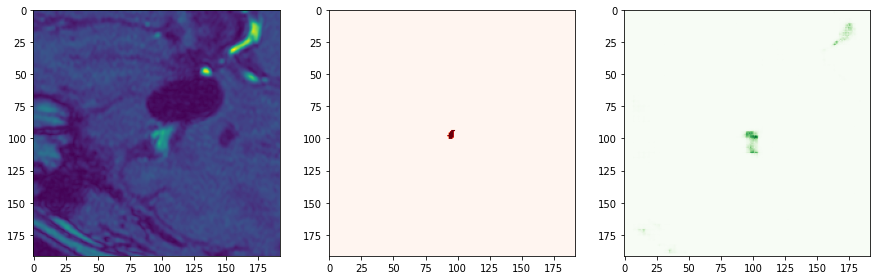

In [17]:
import matplotlib.pyplot as plt

x,y = next(iter(train_data_pipeline))
idx = 1
depth = 32

im = x[idx, depth]
lbl = y[idx, depth]
pred = model.predict(x)[idx, depth].squeeze()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(im)
ax[1].imshow(lbl, cmap='Reds')
ax[2].imshow(pred, cmap='Greens')
plt.show()